In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Mamba2

- [Paper](https://arxiv.org/pdf/2405.21060)
- [Blog posts](https://tridao.me/blog/2024/mamba2-part1-model/)

Mamba2 is a model operating on sequences. The recurrent form loops over events in the sequences and updates a hidden state to compute outputs in the following way ($x$ are the inputs, $h$ the hidden states and $y$ the outputs):

$$h_{t} = exp(A \times dt) \times h_{t-1} + dt \times B \times x_{t}$$
$$y_{t} = C @ h_{t} + D \times x_{t}$$

Note that this differs from the equations from the paper since the paper adds the skip connection term $D \times x_{t}$ in a separate step.

In this equation:
- $A$ and $D$ are learned parameters
- $x_{t}$, $B$, $C$ and $dt$ are computed from the original inputs to the layer
- $h_{0}$ is all zeros and $h_{t}$ is computed by the recurrent formula above

In terms of shapes, the mamba layer has different heads (like a multi-head attention layer). There are two different head dimensions: one for $x_{t}$ and one for $B$/$C$. The shapes of the various tensors are the following:

- $x_{t}$ -> `[batch_size, num_heads, head_size]`
- $A$ -> `[num_heads]`
- $B$ -> `[batch_size, bc_head_size]`
- $C$ -> `[batch_size, bc_head_size]`
- $D$ -> `[num_heads]`
- $dt$ -> `[batch_size, num_heads]`
- $h_{t}$ -> `[batch_size, num_heads, head_size, bc_head_size]`
- $y_{t}$ -> `[batch_size, num_heads, head_size]`

Note that $B$ and $C$ values are shared between heads (a bit like multi-query attention).

In the first equation, all the products are elementwise-products assuming we broadcast everything properly. In terms of code, it would look like this:

```py
h = a[None, :, None, None] * dt[:, :, None, None] * h + dt[:, :, None, None] * b[:, None, None] * x[:, :, :, None]
```

In the second equation, we accumulate on the `bc_head_size` dimension, the rest of the products are elementwise. In terms of code, it would look like this:

```py
y = torch.einsum("bc,bnhc->bnh", c, ssm_state) + d[None, :, None] * x
```

This is just for the SSM update, the model also contains some projections, convolutions and normalization layers. Let's dive into it more.

In [2]:
def get_model_device(model):
    return next(iter(model.parameters())).device

The convolution layers in Mamba2 are 1d conv on the sequence dimension. To be able to apply a convolutional layer on just one event, we need to keep around some of the last events in a state to be able to form a full window. More precisely, we need `kernel_size` events to be able to apply the convolutional layer and get one output, so we keep the `kernel_size-1` last events.

This is all coded in this layer:

In [5]:
class CausalConv1d(nn.Module):
    """
    Causal convolution layer: the hidden state contains the last kernel_size - 1 events
    (zeros initially) so we can have compute the convolution on a full window when
    receiving a new event.
    """

    def __init__(self, hidden_size, kernel_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(
            hidden_size, hidden_size, kernel_size, groups=hidden_size, bias=True
        )

    def init_state(self, batch_size: int, device: torch.device | None = None):
        if device is None:
            device = get_model_device(self)
        return torch.zeros(
            batch_size, self.hidden_size, self.kernel_size - 1, device=device
        )

    def forward(self, x: torch.Tensor, state: torch.Tensor):
        x_with_state = torch.concat([state, x[:, :, None]], dim=-1)
        out = self.conv(x_with_state)
        new_state = x_with_state[:, :, 1:]
        return out.squeeze(-1), new_state

Here is an example of use on random inputs:

In [6]:
batch_size = 4
hidden_size = 32
kernel_size = 4
x = torch.randn(batch_size, hidden_size)

conv = CausalConv1d(hidden_size, kernel_size)
state = conv.init_state(batch_size)
out, new_state = conv(x, state)

Here is a quick overview of the Mamba2 layer:

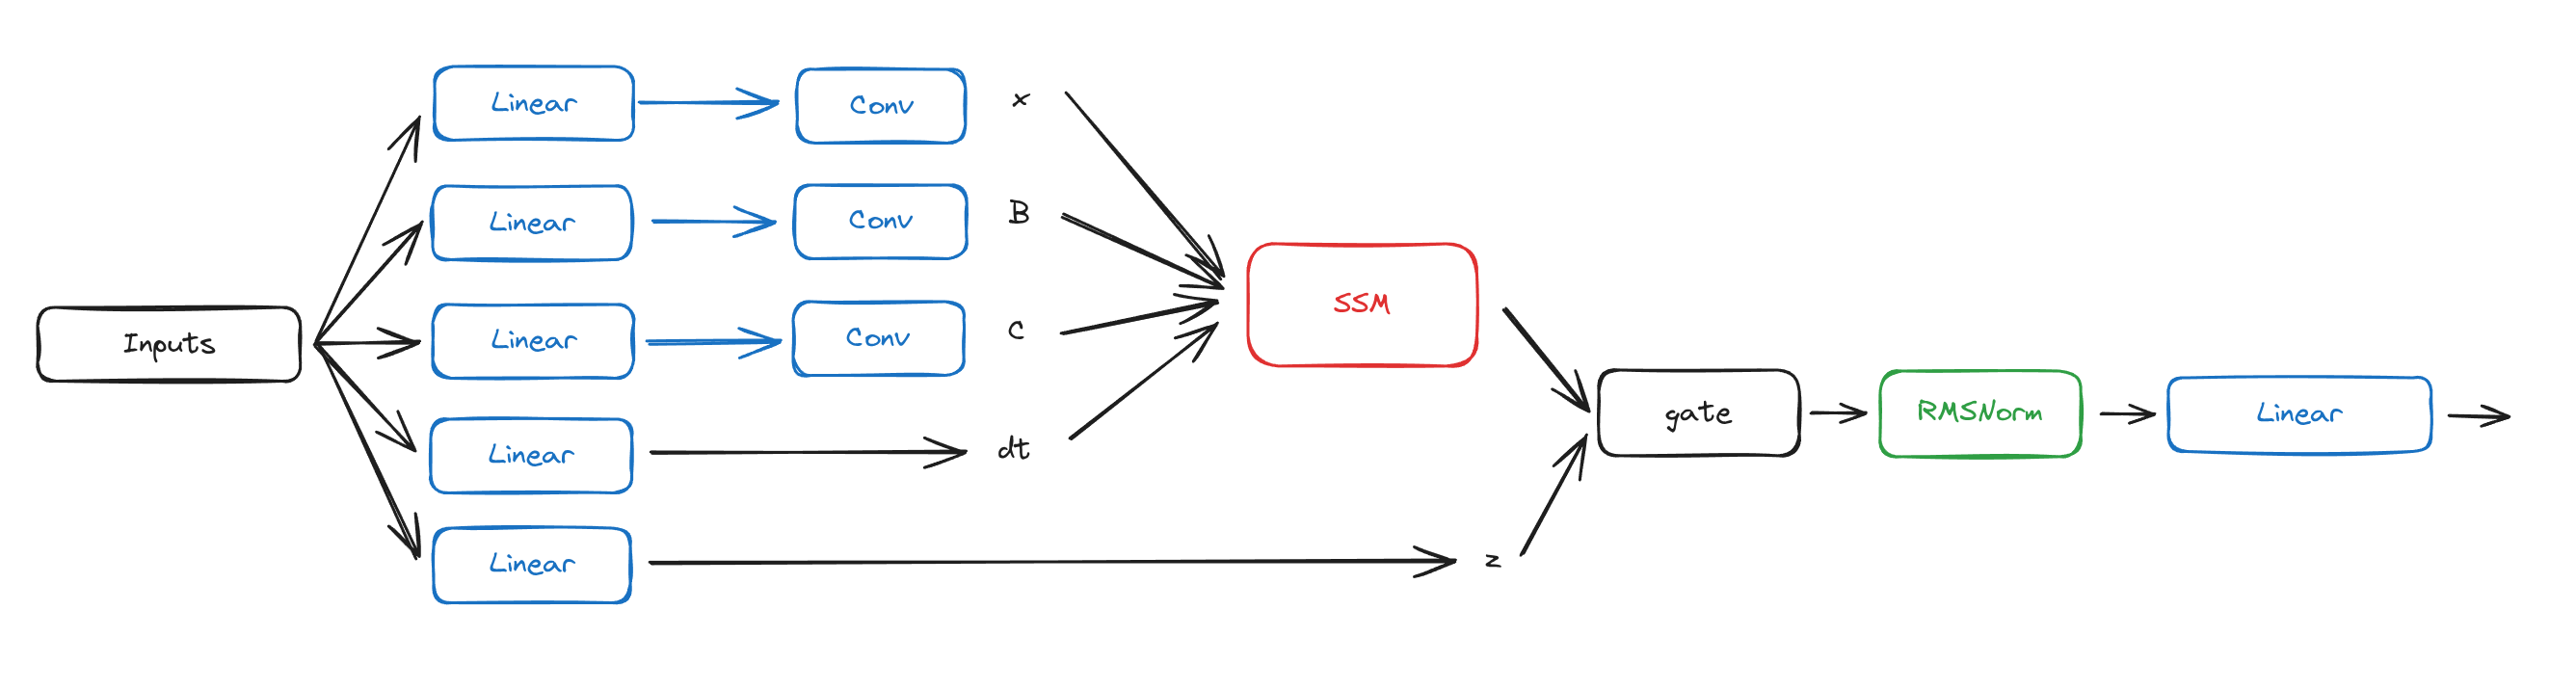

The SSM block has been described above. The gate is just a simple multiplication of `silu(z)` with the SSM output. We can build the model with all of this.

In [4]:
class Mamba2(nn.Module):
    def __init__(
        self,
        hidden_size: int,
        inner_size: int | None = None,
        head_size: int = 64,
        bc_head_size: int = 128,
        conv_kernel_size: int = 4,
    ):
        super().__init__()

        self.head_size = head_size
        self.bc_head_size = bc_head_size
        if inner_size is None:
            inner_size = 2 * hidden_size
        assert inner_size % head_size == 0
        self.inner_size = inner_size
        self.num_heads = inner_size // head_size

        # Projections
        self.input_proj = nn.Linear(hidden_size, inner_size, bias=False)
        self.z_proj = nn.Linear(hidden_size, inner_size, bias=False)
        self.b_proj = nn.Linear(hidden_size, bc_head_size, bias=False)
        self.c_proj = nn.Linear(hidden_size, bc_head_size, bias=False)
        self.dt_proj = nn.Linear(hidden_size, self.num_heads, bias=True)

        # Convs
        self.input_conv = CausalConv1d(inner_size, conv_kernel_size)
        self.b_conv = CausalConv1d(bc_head_size, conv_kernel_size)
        self.c_conv = CausalConv1d(bc_head_size, conv_kernel_size)

        # Other parameters
        self.a = nn.Parameter(-torch.empty(self.num_heads).uniform_(1, 16))
        self.d = nn.Parameter(torch.ones(self.num_heads))

        # Output
        self.norm = nn.RMSNorm(inner_size, eps=1e-5)
        self.out_proj = nn.Linear(inner_size, hidden_size, bias=False)

    def init_state(self, batch_size: int, device: torch.device | None = None):
        if device is None:
            device = get_model_device(self)
        conv_states = [
            conv.init_state(batch_size, device)
            for conv in [self.input_conv, self.b_conv, self.c_conv]
        ]
        ssm_state = torch.zeros(
            batch_size, self.num_heads, self.head_size, self.bc_head_size, device=device
        )
        return conv_states + [ssm_state]

    def forward(self, t, state):
        batch_size = t.shape[0]

        x = self.input_proj(t)
        z = self.z_proj(t)
        b = self.b_proj(t)
        c = self.c_proj(t)
        dt = self.dt_proj(t)

        x_conv_state, b_conv_state, c_conv_state, ssm_state = state
        x, x_conv_state = self.input_conv(x, x_conv_state)
        b, b_conv_state = self.b_conv(b, b_conv_state)
        c, c_conv_state = self.c_conv(c, c_conv_state)
        x = F.silu(x)
        b = F.silu(b)
        c = F.silu(c)

        x = x.view(batch_size, self.num_heads, self.head_size)
        dt = F.softplus(dt)

        # SSM computation, this implements the discretized state space model.
        # new_state computation: h[t] = exp(A*dt) * h[t-1] + dt * B * x[t]
        # [batch_size, num_heads]
        decay = torch.exp(self.a[None] * dt)
        # Broadcasting everything to the right shapes:
        #  dt is [batch_size, num_heads]
        #  b  is [batch_size, bc_head_size]
        #  x  is [batch_size, head_size]
        # The new contribution (and ssm_state) is [batch_size, num_heads, head_size, bc_head_size]
        new_state_contrib = dt[:, :, None, None] * b[:, None, None] * x[:, :, :, None]
        ssm_state = decay[:, :, None, None] * ssm_state + new_state_contrib

        # output computation: y[t] = C @ h[t] + D * x[t]
        # The accumulation in the product of C and h[t] is on the bc_head_size dimension
        state_contrib = torch.einsum("bc,bnhc->bnh", c, ssm_state)
        # d has shape [num_heads], broadcasting it to the shape of x.
        y = state_contrib + self.d[None, :, None] * x

        # Combine heads
        y = y.view(batch_size, self.inner_size)
        # Gate, normalization and out
        y = y * F.silu(z)
        y = self.norm(y)
        output = self.out_proj(y)

        new_state = [x_conv_state, b_conv_state, c_conv_state, ssm_state]
        return output, new_state